In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [2]:
# Merchant profile generator
def generate_merchant_profiles(n_merchants=1000):
    profiles = []
    for i in range(n_merchants):
        merchant = {
            'ID': f'M{i+1:04}',
            'Name': f'Merchant_{i+1}',
            'BusinessType': random.choice(['Retail', 'Wholesale', 'Service']),
            'RegistrationDate': f'2020-{random.randint(1, 12):02}-{random.randint(1, 28):02}',
            'GSTStatus': random.choice(['Active', 'Inactive']),
            'TransactionVolume': random.randint(5000, 50000)
        }
        profiles.append(merchant)
    return pd.DataFrame(profiles)

# Generate transaction data
def generate_transactions(merchant_df, n_transactions_per_merchant=100):
    transactions = []
    for _, merchant in merchant_df.iterrows():
        for _ in range(n_transactions_per_merchant):
            fraud = random.random() < 0.2  # 20% merchants have fraud patterns
            transaction = {
                'MerchantID': merchant['ID'],
                'Timestamp': f"{random.randint(0, 23):02}:{random.randint(0, 59):02}",
                'Amount': random.randint(100, 5000) if not fraud else random.randint(10000, 20000),
                'CustomerID': random.randint(1, 500) if not fraud else random.randint(1, 10),
                'Fraud': fraud
            }
            transactions.append(transaction)
    return pd.DataFrame(transactions)

# Generate data
merchant_df = generate_merchant_profiles()
transaction_df = generate_transactions(merchant_df)


In [3]:
# Calculate derived metrics
def calculate_features(transaction_df):
    features = transaction_df.groupby('MerchantID').agg({
        'Amount': ['mean', 'std', 'max', 'min'],
        'Timestamp': lambda x: sum([1 for t in x if int(t.split(":")[0]) >= 22 or int(t.split(":")[0]) < 6]),
        'CustomerID': lambda x: x.nunique()
    })
    features.columns = ['AmountMean', 'AmountStd', 'AmountMax', 'AmountMin', 'LateNightCount', 'UniqueCustomers']
    return features.reset_index()

# Normalize features
def normalize_features(feature_df):
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(feature_df.iloc[:, 1:])
    return normalized_features, scaler

# Calculate and normalize features
features_df = calculate_features(transaction_df)
normalized_features, scaler = normalize_features(features_df)


In [4]:
# Build the autoencoder model
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)
    return Model(inputs=input_layer, outputs=output_layer)

# Split data into train and test sets
X_train, X_test = train_test_split(normalized_features, test_size=0.2, random_state=42)

# Train the autoencoder
input_dim = X_train.shape[1]
autoencoder = build_autoencoder(input_dim)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0612 - val_loss: 0.0327
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0280 - val_loss: 0.0183
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187 - val_loss: 0.0131
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - val_loss: 0.0109
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0092
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_loss: 0.0060
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_l

In [5]:
# Calculate reconstruction errors
reconstructed = autoencoder.predict(normalized_features)
errors = np.mean(np.power(normalized_features - reconstructed, 2), axis=1)

# Set threshold based on 95th percentile of errors from normal data
threshold = np.percentile(errors, 95)

# Identify anomalies
features_df['AnomalyScore'] = errors
features_df['Anomaly'] = features_df['AnomalyScore'] > threshold


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [6]:
def detect_patterns(transaction_df):
    transaction_df['HighVelocity'] = transaction_df.groupby('MerchantID')['CustomerID'].transform('count') > 50
    transaction_df['OddHourTransaction'] = transaction_df['Timestamp'].apply(lambda t: int(t.split(":")[0]) >= 22 or int(t.split(":")[0]) < 6)
    transaction_df['CustomerConcentration'] = transaction_df.groupby('MerchantID')['CustomerID'].transform(lambda x: x.value_counts().max() > 5)
    return transaction_df

# Detect specific patterns
transaction_df = detect_patterns(transaction_df)


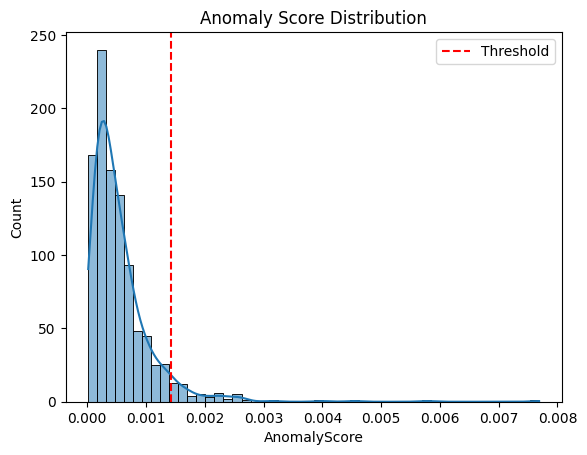

Anomalous Merchants:
    MerchantID  AmountMean    AmountStd  AmountMax  AmountMin  LateNightCount  \
3        M0004     5199.88  5132.266932      19942        134              42   
31       M0032     6221.83  5757.165713      19874        109              30   
48       M0049     4984.39  5124.216784      18428        120              32   
72       M0073     5230.32  5107.413295      19691        145              35   
75       M0076     5977.19  6466.000515      19953        142              29   
76       M0077     7120.99  6341.247522      19955        219              37   
84       M0085     5449.24  5216.882608      19818        125              35   
89       M0090     4852.15  4426.564337      16408        230              32   
105      M0106     3579.30  3982.854931      19823        107              25   
159      M0160     4985.62  5067.169470      19941        125              22   
207      M0208     4312.74  4503.097012      16996        115              36   
208    

In [7]:
# Visualize the results
import seaborn as sns

sns.histplot(features_df['AnomalyScore'], bins=50, kde=True)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Score Distribution')
plt.legend()
plt.show()

# Anomaly merchants
anomaly_merchants = features_df[features_df['Anomaly']]
print("Anomalous Merchants:")
print(anomaly_merchants)


In [8]:
import pandas as pd
import numpy as np
import random

# Generate merchant profiles
def generate_merchant_profiles(n_merchants=1000):
    profiles = []
    for i in range(n_merchants):
        merchant = {
            'MerchantID': f'M{i+1:04}',
            'Name': f'Merchant_{i+1}',
            'BusinessType': random.choice(['Retail', 'Wholesale', 'Service']),
            'RegistrationDate': f'2020-{random.randint(1, 12):02}-{random.randint(1, 28):02}',
        }
        profiles.append(merchant)
    return pd.DataFrame(profiles)

# Generate transaction data
def generate_transactions(merchant_df, n_transactions_per_merchant=100):
    transactions = []
    for _, merchant in merchant_df.iterrows():
        is_fraudulent = random.random() < 0.2  # 20% merchants with fraud patterns
        for _ in range(n_transactions_per_merchant):
            late_night = is_fraudulent and random.random() < 0.5
            high_velocity = is_fraudulent and random.random() < 0.5
            concentrated_customer = is_fraudulent and random.random() < 0.5

            transaction = {
                'MerchantID': merchant['MerchantID'],
                'Timestamp': f"{random.randint(22, 23) if late_night else random.randint(8, 21):02}:{random.randint(0, 59):02}",
                'Amount': random.randint(10000, 50000) if high_velocity else random.randint(100, 10000),
                'CustomerID': random.randint(1, 10) if concentrated_customer else random.randint(1, 500),
            }
            transactions.append(transaction)
    return pd.DataFrame(transactions)

# Generate merchant and transaction data
merchant_df = generate_merchant_profiles()
transaction_df = generate_transactions(merchant_df)


In [9]:
# Calculate features
def calculate_features(transaction_df):
    features = transaction_df.groupby('MerchantID').agg({
        'Amount': ['mean', 'std', 'max', 'min'],
        'Timestamp': lambda x: sum(1 for t in x if int(t.split(":")[0]) >= 22 or int(t.split(":")[0]) < 6),
        'CustomerID': lambda x: x.value_counts().max()
    })
    features.columns = ['AmountMean', 'AmountStd', 'AmountMax', 'AmountMin', 'LateNightCount', 'MaxCustomerConcentration']
    features['TransactionCount'] = transaction_df.groupby('MerchantID').size()
    return features.reset_index()

# Normalize features
from sklearn.preprocessing import MinMaxScaler

def normalize_features(feature_df):
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(feature_df.iloc[:, 1:])
    return normalized_features, scaler

# Feature calculation and normalization
features_df = calculate_features(transaction_df)
normalized_features, scaler = normalize_features(features_df)


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Build the autoencoder model
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)
    return Model(inputs=input_layer, outputs=output_layer)

# Split into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(normalized_features, test_size=0.2, random_state=42)

# Train the autoencoder
input_dim = X_train.shape[1]
autoencoder = build_autoencoder(input_dim)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1911 - val_loss: 0.1495
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1144 - val_loss: 0.0168
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_lo

In [12]:
# Calculate reconstruction error
reconstructed = autoencoder.predict(normalized_features)
errors = np.mean(np.power(normalized_features - reconstructed, 2), axis=1)

# Set anomaly threshold
threshold = np.percentile(errors, 95)

# Add anomaly scores
features_df['AnomalyScore'] = errors
features_df['Anomaly'] = features_df['AnomalyScore'] > threshold

# Rule-based detection
def apply_rules(features_df):
    features_df['HighVelocity'] = features_df['TransactionCount'] > features_df['TransactionCount'].quantile(0.95)
    features_df['OddHourPattern'] = features_df['LateNightCount'] > features_df['LateNightCount'].quantile(0.95)
    features_df['CustomerConcentration'] = features_df['MaxCustomerConcentration'] > features_df['MaxCustomerConcentration'].quantile(0.95)
    return features_df

# Apply rules
features_df = apply_rules(features_df)

# Pattern-specific scores
features_df['PatternScore'] = (
    0.4 * features_df['HighVelocity'].astype(int) +
    0.3 * features_df['OddHourPattern'].astype(int) +
    0.3 * features_df['CustomerConcentration'].astype(int)
)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


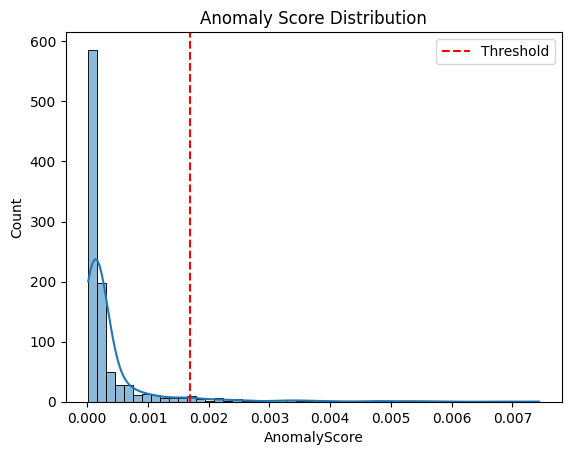

Anomalous Merchants:
    MerchantID  AmountMean     AmountStd  AmountMax  AmountMin  \
44       M0045    18691.05  15190.032089      49810        206   
66       M0067    20000.02  15305.682081      48087        214   
76       M0077    19276.17  16580.476118      49430        121   
81       M0082    15311.75  14166.611281      46760        160   
83       M0084    20364.23  16444.198303      49738        537   
99       M0100    15582.35  13349.173260      49328        338   
149      M0150    20645.89  15778.180171      49725        128   
180      M0181    21330.00  15346.488949      49972        954   
218      M0219    18127.14  16087.473623      49907        391   
254      M0255    19907.64  16069.749212      48991        131   
258      M0259    17259.21  15324.280226      49815        353   
263      M0264    19898.13  15331.114337      48287        170   
266      M0267    15513.96  14723.417009      49806        315   
308      M0309    18908.02  16004.365593      49299    

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize anomaly scores
sns.histplot(features_df['AnomalyScore'], bins=50, kde=True)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Score Distribution')
plt.legend()
plt.show()

# View anomalous merchants
anomalies = features_df[features_df['Anomaly']]
print("Anomalous Merchants:")
print(anomalies)

# Check merchants flagged by specific rules
pattern_flags = features_df[(features_df['HighVelocity']) |
                            (features_df['OddHourPattern']) |
                            (features_df['CustomerConcentration'])]
print("Merchants flagged by specific patterns:")
print(pattern_flags)


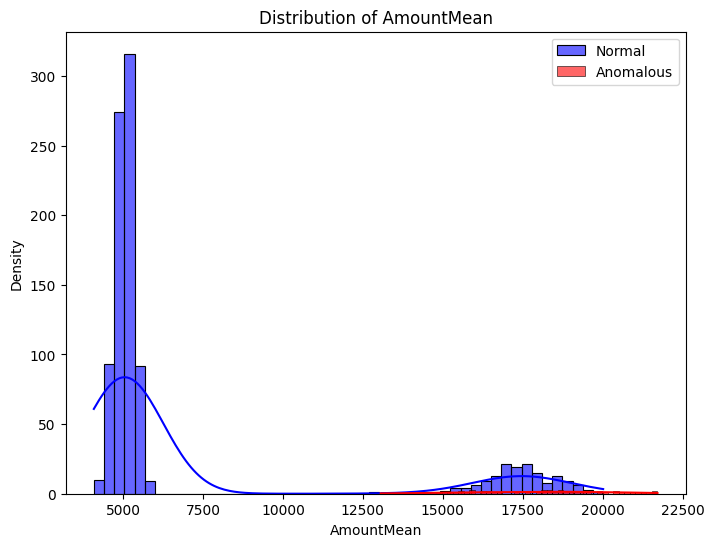

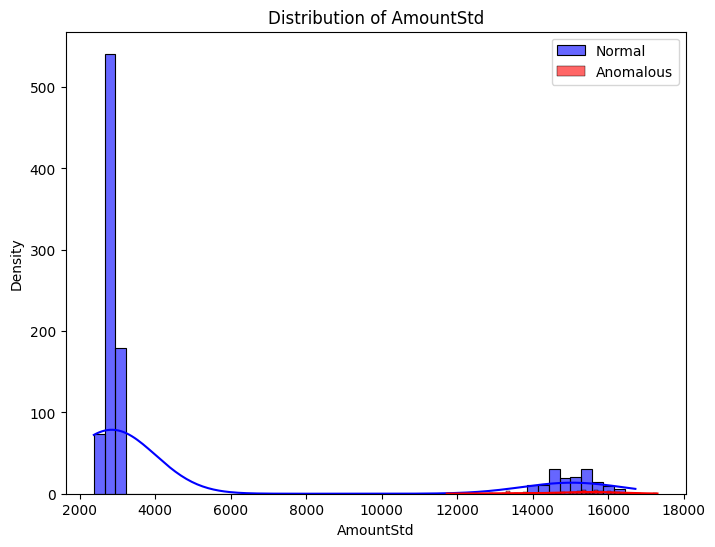

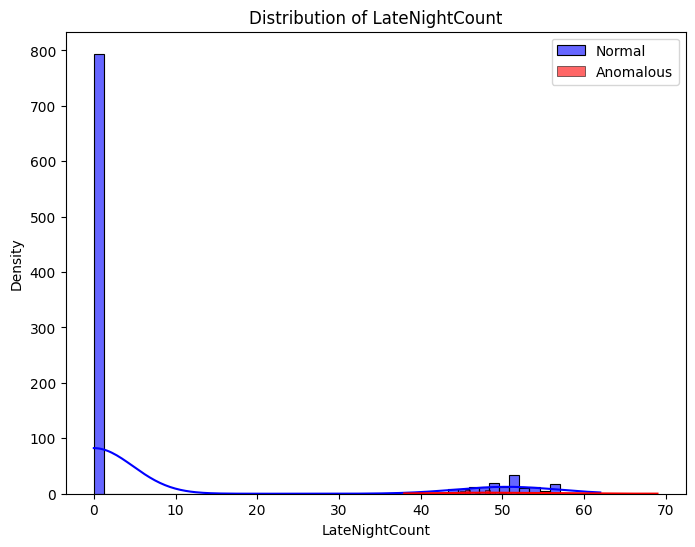

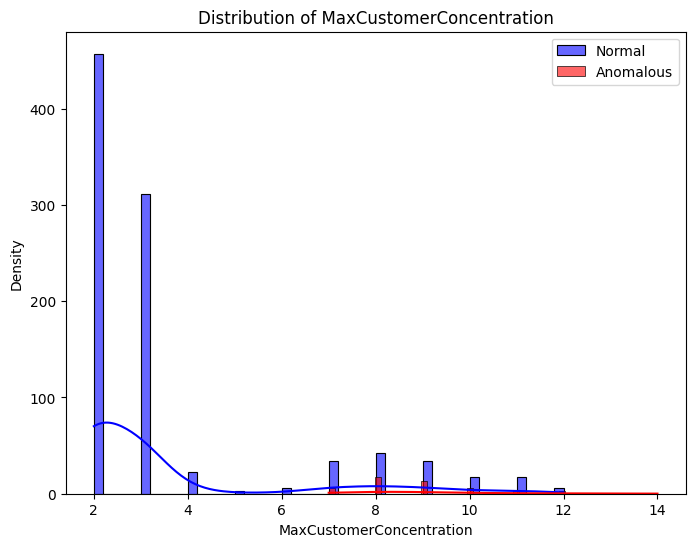

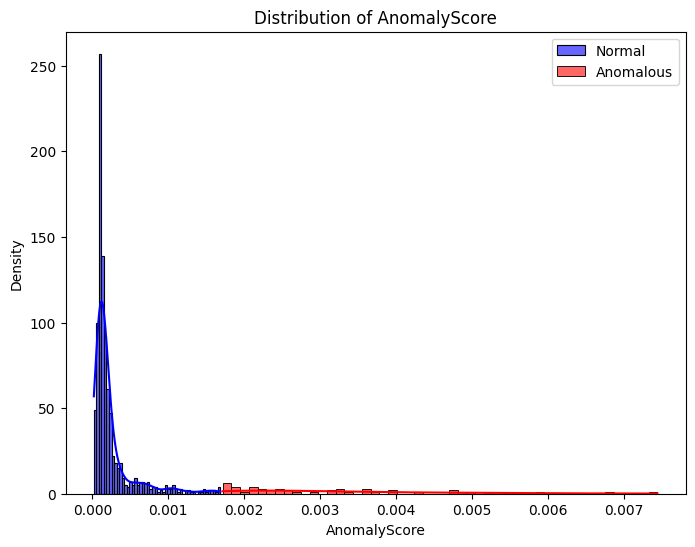

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot feature distributions
def plot_feature_distributions(features_df, feature_names, anomalies):
    for feature in feature_names:
        plt.figure(figsize=(8, 6))
        sns.histplot(features_df[~anomalies][feature], bins=50, kde=True, color='blue', label='Normal', alpha=0.6)
        sns.histplot(features_df[anomalies][feature], bins=50, kde=True, color='red', label='Anomalous', alpha=0.6)
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend()
        plt.show()

# Specify features to visualize
features_to_plot = ['AmountMean', 'AmountStd', 'LateNightCount', 'MaxCustomerConcentration', 'AnomalyScore']

# Plot distributions
anomalies = features_df['Anomaly']
plot_feature_distributions(features_df, features_to_plot, anomalies)


In [32]:
import numpy as np
import pandas as pd
!pip install faker
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from scipy.stats import wasserstein_distance, kurtosis, skew
from faker import Faker
from datetime import datetime, timedelta
import networkx as nx

class AdvancedMerchantAnomalyDetector:
    def __init__(self, random_seed=42):
        """
        Initialize the Advanced Merchant Anomaly Detection System

        Args:
            random_seed (int): Seed for reproducibility
        """
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)
        self.faker = Faker()
        self.standard_scaler = StandardScaler()
        self.robust_scaler = RobustScaler()

    def generate_merchant_profiles(self, num_merchants=2000):
        """
        Generate synthetic merchant profiles
        """
        business_types = ['Retail', 'Restaurant', 'Online Services', 'Manufacturing',
                          'Consulting', 'Technology', 'E-commerce', 'Hospitality', 'Healthcare']
        risk_categories = ['Low Risk', 'Medium Risk', 'High Risk']

        merchants = []
        for _ in range(num_merchants):
            registration_date = self.faker.date_between(start_date='-7y', end_date='today')
            merchant = {
                'merchant_id': self.faker.uuid4(),
                'name': self.faker.company(),
                'business_type': np.random.choice(business_types),
                'registration_date': registration_date,
                'gst_status': np.random.choice(['Registered', 'Unregistered'], p=[0.7, 0.3]),
                'annual_turnover': np.random.lognormal(mean=10, sigma=1),
                'risk_category': np.random.choice(risk_categories, p=[0.6, 0.3, 0.1]),
                'geographical_region': self.faker.country_code(),
                'business_age_years': (datetime.now() - pd.to_datetime(registration_date)).days / 365
            }
            merchants.append(merchant)
        return pd.DataFrame(merchants)

    def generate_transaction_data(self, merchant_profiles, transactions_per_merchant=100):
        """
        Generate transaction data with fraud patterns
        """
        transactions = []
        fraud_probabilities = {'Low Risk': 0.05, 'Medium Risk': 0.2, 'High Risk': 0.5}

        for _, merchant in merchant_profiles.iterrows():
            fraud_prob = fraud_probabilities[merchant['risk_category']]
            for _ in range(transactions_per_merchant):
                is_fraudulent = np.random.random() < fraud_prob
                timestamp = self._generate_timestamp(is_fraudulent)
                amount = self._generate_amount(is_fraudulent, merchant['annual_turnover'])
                transaction = {
                    'merchant_id': merchant['merchant_id'],
                    'timestamp': timestamp,
                    'amount': amount,
                    'customer_id': self.faker.uuid4(),
                    'is_fraudulent': is_fraudulent
                }
                transactions.append(transaction)
        return pd.DataFrame(transactions)

    def _generate_timestamp(self, is_fraudulent):
      """
      Generate transaction timestamps with advanced fraud patterns

      Args:
          is_fraudulent (bool): Whether the transaction is fraudulent

      Returns:
          datetime: Generated timestamp
      """
      if is_fraudulent:
          # Extreme time distributions for fraudulent transactions
          fraud_hours = [0, 1, 2, 23, 22, 21]
          hour = int(np.random.choice(fraud_hours))
      else:
          # Normal business hour distribution with some variance
          hour = int(np.random.normal(12, 2)) % 24  # Assuming 12 as the cluster_hour
      return datetime.now() - timedelta(
          days=int(np.random.randint(0, 365)),
          hours=hour  # Convert to Python int
      )



    def _generate_amount(self, is_fraudulent, turnover):
        """
        Generate transaction amounts
        """
        base_amount = np.random.lognormal(mean=np.log(turnover * 0.0005), sigma=1)
        if is_fraudulent:
            multiplier = np.random.uniform(2, 10)
            return base_amount * multiplier
        return base_amount

    def engineer_features(self, transactions, merchant_profiles):
        """
        Feature engineering
        """
        transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])

        features = transactions.groupby('merchant_id').agg({
            'amount': ['mean', 'std', 'max', 'min', skew, kurtosis],
            'timestamp': lambda x: (x.max() - x.min()).total_seconds() / 86400,
            'customer_id': 'nunique',
            'is_fraudulent': 'mean'
        }).reset_index()

        features.columns = ['merchant_id', 'mean_amount', 'std_amount', 'max_amount', 'min_amount',
                            'amount_skewness', 'amount_kurtosis', 'days_active',
                            'unique_customers', 'fraud_ratio']

        return features.merge(merchant_profiles, on='merchant_id', how='left')

    def create_autoencoder(self, input_dim):
        """
        Create an autoencoder model
        """
        input_layer = tf.keras.layers.Input(shape=(input_dim,))
        encoded = tf.keras.layers.Dense(input_dim // 2, activation='relu')(input_layer)
        encoded = tf.keras.layers.Dense(input_dim // 4, activation='relu')(encoded)
        decoded = tf.keras.layers.Dense(input_dim // 2, activation='relu')(encoded)
        decoded = tf.keras.layers.Dense(input_dim, activation='linear')(decoded)
        autoencoder = tf.keras.Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder

    def detect_anomalies(self, features, threshold_percentile=95):
        """
        Anomaly detection
        """
        # Ensure 'merchant_id' is kept as a separate column
        merchant_ids = features['merchant_id']

        # Select only numerical features and drop 'merchant_id' if present
        X = features.select_dtypes(include=np.number)
        if 'merchant_id' in X.columns:
            X = X.drop('merchant_id', axis=1)

        # Scale features
        X_scaled = self.standard_scaler.fit_transform(X)

        # Create and train autoencoder if not already done
        if not hasattr(self, 'autoencoder'):
            input_dim = X_scaled.shape[1]
            self.autoencoder = self.create_autoencoder(input_dim)
            self.autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

        # Get reconstruction error
        reconstructed_data = self.autoencoder.predict(X_scaled)  # Get reconstructed data
        reconstruction_error = np.mean(np.power(X_scaled - reconstructed_data, 2), axis=1)  # Calculate error

        # Determine anomalies
        threshold = np.percentile(reconstruction_error, threshold_percentile)
        anomalies = reconstruction_error > threshold

        return pd.DataFrame({
            'merchant_id': merchant_ids,  # Use the stored merchant_ids
            'reconstruction_error': reconstruction_error,
            'is_anomalous': anomalies
        })

def main():
    detector = AdvancedMerchantAnomalyDetector()
    merchant_profiles = detector.generate_merchant_profiles()
    transactions = detector.generate_transaction_data(merchant_profiles)
    features = detector.engineer_features(transactions, merchant_profiles)
    anomalies = detector.detect_anomalies(features)


# Assuming `features_data` is a DataFrame
    features.to_csv("features_data.csv", index=False)

    print("Anomaly Detection Summary:")
    print(f"Total Merchants: {len(anomalies)}")
    print(f"Anomalous Merchants: {anomalies['is_anomalous'].sum()}")
    print("\nSample Anomalies:")
    print(anomalies[anomalies['is_anomalous']].head())
    print(pd.DataFrame(features))
    print(pd.DataFrame(transactions))
    print(pd.DataFrame(merchant_profiles))

if __name__ == "__main__":
    main()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Anomaly Detection Summary:
Total Merchants: 2000
Anomalous Merchants: 100

Sample Anomalies:
                             merchant_id  reconstruction_error  is_anomalous
26  0300a843-b80e-440e-ae34-e6ae7c5994f7              1.348840          True
48  05be1d55-51e3-4599-a16e-975a12c1a0f2              1.065490          True
68  09424625-f24c-4597-9992-55353b839139              1.458706          True
70  095987ea-e993-41b1-b589-1342e70445c8              1.157452          True
95  0d61fda7-d7ae-4c99-a0bd-2da99f247938              1.170436          True
                               merchant_id  mean_amount  std_amount  \
0     001535b2-4921-4029-b3a0-fdf9ea947f3f    82.121474  150.156933   
1     001fa051-97f9-4f4a-af20-420a9eef08c3    18.746614   75.245216   
2     00386697-fd23-4269-8fec-5e0baab715fb     6.926975   14.111729   
3     004c11a2-1145-4165-a664-090c83095c13    75.911829  138.728441   
4     005cc43b-1fd8-4736-be2a-19874cf37da5    80.80

In [34]:
df = pd.read_csv("features_data.csv")
df


,merchant_id,mean_amount,std_amount,max_amount,min_amount,amount_skewness,amount_kurtosis,days_active,unique_customers,fraud_ratio,name,business_type,registration_date,gst_status,annual_turnover,risk_category,geographical_region,business_age_years
0,001535b2-4921-4029-b3a0-fdf9ea947f3f,82.121474,150.156933,1291.120700,3.795709,5.722493,40.901390,360.458333,100,0.04,Coleman Inc,Healthcare,2020-12-03,Registered,75217.379927,Low Risk,CN,3.994521
1,001fa051-97f9-4f4a-af20-420a9eef08c3,18.746614,75.245216,742.102430,0.808351,9.085229,84.273788,364.083333,100,0.07,Spencer LLC,Healthcare,2017-12-24,Unregistered,11582.408264,Low Risk,BJ,6.939726
2,00386697-fd23-4269-8fec-5e0baab715fb,6.926975,14.111729,113.107784,0.091367,5.268156,32.963461,361.041667,100,0.08,"Meyers, Mckee and Ayers",Manufacturing,2022-11-14,Registered,6176.945811,Low Risk,KI,2.046575
3,004c11a2-1145-4165-a664-090c83095c13,75.911829,138.728441,780.266568,2.940620,3.564565,13.139755,363.083333,100,0.18,Hensley-Anderson,Retail,2022-12-23,Registered,44668.880819,Medium Risk,FM,1.939726
4,005cc43b-1fd8-4736-be2a-19874cf37da5,80.802381,163.193815,1325.843134,1.541075,5.175876,33.360596,360.541667,100,0.05,Garcia Inc,Technology,2023-03-16,Registered,56386.261540,Low Risk,NO,1.712329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ff8f5135-67f0-4e08-8d96-530437547aa8,52.829572,110.617771,1063.278612,2.129643,7.818117,68.177988,361.166667,100,0.06,"Mason, Hudson and Garza",Online Services,2018-10-14,Registered,49493.391568,Low Risk,TV,6.134247
1996,ffa5e6a2-6392-4e3e-b860-8a71d0ca9e5c,74.632818,122.374409,796.362132,3.707984,4.175785,19.256079,360.375000,100,0.05,Greene PLC,E-commerce,2020-07-15,Registered,80674.491016,Low Risk,JO,4.380822
1997,ffab1a6b-729e-44e6-be33-d571f49477ba,33.149221,38.751336,273.552703,1.508392,3.493687,15.949519,355.041667,100,0.05,May PLC,Technology,2021-03-10,Unregistered,41797.090338,Low Risk,VA,3.728767
1998,ffbbd555-9350-4bf9-bae7-befcd036fddb,45.900346,146.210918,1160.033995,1.482292,6.529148,43.267122,355.125000,100,0.09,Johnson-Hines,Healthcare,2019-06-25,Unregistered,23427.828569,Low Risk,DM,5.438356


from matplotlib import pyplot as plt
df['mean_amount'].plot(kind='hist', bins=20, title='mean_amount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['std_amount'].plot(kind='hist', bins=20, title='std_amount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['max_amount'].plot(kind='hist', bins=20, title='max_amount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['min_amount'].plot(kind='hist', bins=20, title='min_amount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('gst_status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('risk_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='mean_amount', y='std_amount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='std_amount', y='max_amount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='max_amount', y='min_amount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='min_amount', y='amount_skewness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['unique_customers']
  ys = series['mean_amount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('unique_customers', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gst_status')):
  _plot_series(series, series_name, i)
  fig.legend(title='gst_status', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('unique_customers')
_ = plt.ylabel('mean_amount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['unique_customers']
  ys = series['mean_amount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('unique_customers', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('risk_category')):
  _plot_series(series, series_name, i)
  fig.legend(title='risk_category', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('unique_customers')
_ = plt.ylabel('mean_amount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['unique_customers']
  ys = series['std_amount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('unique_customers', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gst_status')):
  _plot_series(series, series_name, i)
  fig.legend(title='gst_status', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('unique_customers')
_ = plt.ylabel('std_amount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['unique_customers']
  ys = series['std_amount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('unique_customers', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('risk_category')):
  _plot_series(series, series_name, i)
  fig.legend(title='risk_category', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('unique_customers')
_ = plt.ylabel('std_amount')

from matplotlib import pyplot as plt
df['mean_amount'].plot(kind='line', figsize=(8, 4), title='mean_amount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['std_amount'].plot(kind='line', figsize=(8, 4), title='std_amount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['max_amount'].plot(kind='line', figsize=(8, 4), title='max_amount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['min_amount'].plot(kind='line', figsize=(8, 4), title='min_amount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['risk_category'].value_counts()
    for x_label, grp in df.groupby('gst_status')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gst_status')
_ = plt.ylabel('risk_category')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['gst_status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='mean_amount', y='gst_status', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['risk_category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='mean_amount', y='risk_category', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['gst_status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='std_amount', y='gst_status', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['risk_category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='std_amount', y='risk_category', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)